# Building Spark Session

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Clustering").getOrCreate()

spark

# Reading the dataset

In [3]:
path = "Dataset/"
df = spark.read.csv(path + "credit_card_data.csv", inferSchema = True, header = True)

In [4]:
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [6]:
print("The size of this dataset is {}*{}".format(df.count(), len(df.columns)))

The size of this dataset is 8950*18


# Null Values handling

In [7]:
na_dict = {}
for i in range(len(df.columns)):
    column = df.columns[i]
    num_na = df.select(column).na.drop().count()
    na_dict[column] = num_na

In [8]:
na_df = pd.DataFrame([na_dict.keys(), na_dict.values()]).T
na_df.head(20)

,0,1
0,CUST_ID,8950
1,BALANCE,8950
2,BALANCE_FREQUENCY,8950
3,PURCHASES,8950
4,ONEOFF_PURCHASES,8950
5,INSTALLMENTS_PURCHASES,8950
6,CASH_ADVANCE,8950
7,PURCHASES_FREQUENCY,8950
8,ONEOFF_PURCHASES_FREQUENCY,8950
9,PURCHASES_INSTALLMENTS_FREQUENCY,8950


### As is show, the only columns with more than 300 Null values is Minimum_Payment

In [9]:
max_bound = df.groupby().max('MINIMUM_PAYMENTS').first().asDict()['max(MINIMUM_PAYMENTS)']
min_bound = df.groupby().min('MINIMUM_PAYMENTS').first().asDict()['min(MINIMUM_PAYMENTS)']
mean_value = df.groupby().mean('MINIMUM_PAYMENTS').first().asDict()['avg(MINIMUM_PAYMENTS)']
print("The Maximum of this column: {}".format(max_bound))
print("The Minimum of this column: {}".format(min_bound))
print("The Mean Value of this column: {}".format(mean_value))

The Maximum of this column: 76406.20752
The Minimum of this column: 0.019163
The Mean Value of this column: 864.2065423050816


### Let's Consider the mean value of this column for the missing 300 samples

In [10]:
df = df.fillna({'MINIMUM_PAYMENTS':mean_value}).na.drop()

In [11]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = false)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



# Vectorizing the dataset

In [12]:
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols=df.columns[1:], outputCol='features')
train = vector_assembler.transform(df)

In [13]:
train.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,features
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0...."
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94..."
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1..."
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2..."
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,"[817.714335, 1.0, 16.0, 16.0, 0.0, 0.0, 0.0833..."


# K-means

In [14]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmax = 30

kmeans_cost = np.zeros(kmax)

for k in range(2,kmax):
    
    kmeans = KMeans(k = k, seed=3,featuresCol='features')
    fitModel_km = kmeans.fit(train)
    predictions = fitModel_km.transform(train)
    
    evaluator = ClusteringEvaluator(distanceMeasure='squaredEuclidean')
    kmeans_cost[k] = evaluator.evaluate(predictions)

## Determine the number of clusters

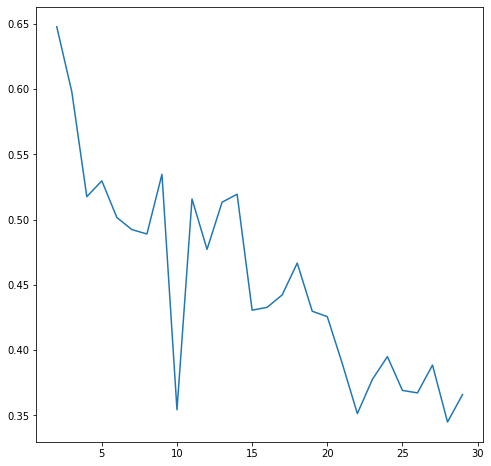

In [15]:
plt.figure(figsize = [8,8])
plt.plot(np.arange(2,kmax),kmeans_cost[2:])

### As is shown, the best number of clusters for KMeans is 10

In [16]:
km = KMeans(featuresCol= 'features', k = 10)
fitModel_km = km.fit(train)
predictions_km = fitModel_km.transform(train)
print("The cluster_sizes of this model is {}".format(fitModel_km.summary.clusterSizes))
predictions_km.groupby("prediction").count().orderBy('prediction').show(10)

The cluster_sizes of this model is [4694, 391, 906, 36, 84, 20, 372, 890, 109, 1447]
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 4694|
|         1|  391|
|         2|  906|
|         3|   36|
|         4|   84|
|         5|   20|
|         6|  372|
|         7|  890|
|         8|  109|
|         9| 1447|
+----------+-----+



In [22]:
predictions_km.columns

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE',
 'features',
 'prediction']

In [39]:
from pyspark.sql.functions import *
Purchase_Balance = predictions_km.groupby("prediction").agg(max("PURCHASES").alias('Max_Purchase'),
                                         max("BALANCE").alias('Max_Balance'),
                                         min("PURCHASES").alias('Min_Purchase'),
                                         min("BALANCE").alias('Min_Balance'),
                                         avg("PURCHASES").alias('Mean_Purchase'),
                                         avg("BALANCE").alias('Mean_Balance'),
                                         stddev("PURCHASES").alias('Std_Purchase'),
                                         stddev("BALANCE").alias('Std_Balance'))

In [46]:
Purchase_Balance.sort(desc("Mean_Purchase")).select("Mean_Purchase","Mean_Balance","prediction").toPandas()

,Mean_Purchase,Mean_Balance,prediction
0,29175.132000,5626.564299,5
1,10818.985952,4253.358203,4
2,4840.877984,1973.053819,6
3,1593.088977,5500.337193,1
4,1546.991943,1228.348551,2
5,1274.465138,5097.271867,8
6,918.267222,4250.150569,3
7,889.147650,842.855480,9
8,478.620404,4548.560120,7
9,378.475409,758.050243,0


# Bi-secting K-means

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

bkmax = 30

bkmeans_cost = np.zeros(bkmax)

for k in range(2,bkmax):
    
    bkmeans = BisectingKMeans(k = k, seed=3,featuresCol='features')
    fitModel_bkm = bkmeans.fit(train)
    predictions = fitModel_bkm.transform(train)
    
    evaluator = ClusteringEvaluator(distanceMeasure='squaredEuclidean')
    bkmeans_cost[k] = evaluator.evaluate(predictions)

## Determine the number of clusters

In [ ]:
plt.figure(figsize = [8,8])
plt.plot(np.arange(2,bkmax),bkmeans_cost[2:])

### As is shown, the best number of clusters for Bisecting KMeans is 9

In [ ]:
bkm = BisectingKMeans(featuresCol= 'features', k = 10)
fitModel_bkm = km.fit(train)

print("The cluster_sizes of this model is {}".format(fitModel_bkm.summary.clusterSizes))

# Gaussian Mixture Clustering

## Determine the number of clusters

In [ ]:
from pyspark.ml.clustering import GaussianMixture

gmmax = 50
loglikelihood = np.zeros(gmmax)

for k in range(2, gmmax):
    gm = GaussianMixture(featuresCol = 'features', k = k, tol = 0.0001, maxIter=10, seed = 10)
    fitModel_gm = gm.fit(train)
    ll = fitModel_gm.summary.logLikelihood
    loglikelihood[k] = ll

In [ ]:
plt.figure(figsize = [18,8])
plt.plot(np.arange(2,gmmax,5),loglikelihood[2::5])
plt.xlabel('Number of Clusters')
plt.ylabel('loglikelihood')
plt.grid(True)

### As is observed, 10 or 20 cluters are suitable for Gaussian Matrix clustering

# Extracting some information from the dataset using the clustering models

In [ ]:
gm = GaussianMixture(featuresCol= 'features', k = 40, tol = 0.1, maxIter = 1000)
fitModel_gm = gm.fit(train)

print("The loglikelihood of this model is {}".format(fitModel_gm.summary.logLikelihood))
print("The cluster_sizes of this model is {}".format(fitModel_gm.summary.clusterSizes))